# Time-series prediction using a seq2seq model

### Version: v1.2
#### Main features/components: grid search, seq2seq model (variable seq length and dimension), mock dataset generation, TF Model export. The input and output tensors (for TF Serving export) in this version are multidimensional.

### Licenses/Credits
* Copyright (c) 2019, PatternedScience Inc. This code was originally run on the [UniAnalytica platform](https://www.unianalytica.com/), is published by PatternedScience Inc. on GitHub and is licensed under the terms of Apache License 2.0; a copy of the license is available in the GitHub repository;

* The seq2seq model, mock dataset generation, and the visualization code snippets are based on [the work by Guillaume Chevalier](https://github.com/guillaume-chevalier/seq2seq-signal-prediction) (MIT License).

* Adding seq2seq decoder input feedback mechanism to the model through a modification based on code done by [Weimin Wang](https://github.com/aaxwaz/Multivariate-Time-Series-forecast-using-seq2seq-in-TensorFlow/blob/master/build_model_basic.py#L75)

### Package imports

In [1]:
import os
from os.path import isdir, join
import sys
from sys import exc_info
import logging
import shutil
import time
from datetime import datetime
import pytz
import random
import math
from operator import itemgetter
import itertools
import numpy as np
print('Numpy version: ' + np.__version__)
import pandas as pd
print('Pandas version: ' + pd.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

Numpy version: 1.16.2
Pandas version: 0.24.1


### Package imports (TensorFlow)

In [2]:
logging.getLogger('tensorflow').disabled = True # Disabling TF logging
import tensorflow as tf
print('TensorFlow version: ' + tf.__version__)
from tensorflow.core.framework import summary_pb2
from tensorflow.python.client import device_lib
# Letting the code run with more recent versions of TF:
tf.nn.seq2seq = tf.contrib.legacy_seq2seq
tf.nn.rnn_cell = tf.contrib.rnn
tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell

# 4 imports related to seq2seq feedback version:
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
from tensorflow.contrib import rnn
import copy

from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']
print('-------------------------')
print('GPU info: ' + str(get_available_gpus()))
print('-------------------------')

TensorFlow version: 1.13.1

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

-------------------------
GPU info: ['device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0']
-------------------------


### Fixed global params

In [3]:
# Parameters that are commented are moved to the grid search parameters section
params = {}
params['parent_dir'] = '/workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full'
params['experiments_results_dir'] = join(params['parent_dir'],'experiments_results')
params['saved_models_dir'] = join(params['parent_dir'],'saved_models') # Saving the session for reload during testing
params['exported_models_dir'] = join(params['parent_dir'],'exported_models')

params['exported_model_version'] = 1 # Integer (for TensorFlow Serving use)

params['is_plotting_predictions'] = True
params['nb_predictions'] = 5

params['is_plotting_losses'] = True

params['seq_length_in'] = 10
params['seq_length_out'] = 5

params['input_dim'] = 1 # 1 or 2
params['output_dim'] = 1 # 1 or 2

params['dataset_size'] = 1000
params['trainset_portion'] = 0.6
params['validset_portion'] = 0.2

params['batch_size'] = 32  # 5, 100
params['num_epoch'] = 5

params['lr_decay'] = 0.92  # (default: 0.9), 0.92
params['momentum'] = 0.5  # (default: 0.0), 0.5
params['lambda_l2_reg'] = 0.003  # 0.003
params['init_learning_rate'] = 0.007

### GridSearch params

In [4]:
#params['hidden_dim'] = 12  # Count of hidden neurons in the recurrent units. 
#params['layers_stacked_count'] = 2  # Number of stacked recurrent cells, on the neural depth axis. 

params['seq2seq_type'] = 'orig_tf_seq2seq' # 'orig_tf_seq2seq', 'decoder_feedback', 'decoder_feedback_disabled'
# decoder_feedback: the output of the decoder at time t is fed back and becomes the input of the decoder at time t+1
# decoder_feedback_disabled: it is technically like orig_tf_seq2seq, but it uses the local functions defined here, instead of original TF functions

grid_params = [
   zip(['hidden_dim' for _ in range(2)],[12,24])
   ,zip(['layers_stacked_count' for _ in range(2)],[1,2])
   ,zip(['seq2seq_type' for _ in range(3)],['orig_tf_seq2seq', 'decoder_feedback'])
]

# Make sure the items under the above "Fixed global params" and "GridSearch params" are 
# all mentioned in the section "Copying from params dict to local vars" in runExperiment() function below

### Creating the directories that hold the results
Creating these sub-directories under parent_dir: `experiments_results`, `saved_models`, `exported_models`

#### If they exist already, THEY ARE DELETED ALONG WITH THEIR CONTENTS.

In [5]:
if isdir(params['experiments_results_dir']):
    try:
        shutil.rmtree(params['experiments_results_dir'])
    except:
        print('Cound not delete the existing directory: ' + params['experiments_results_dir'])
        e = exc_info()[0]
        print("Error: %s" % e)    
try:
    os.makedirs(params['experiments_results_dir'])
except:
    print('Cound not create directory: ' + params['experiments_results_dir'])
    e = sys.exc_info()[0]
    print("Error: %s" % e)
    
if isdir(params['saved_models_dir']):
    try:
        shutil.rmtree(params['saved_models_dir'])
    except:
        print('Cound not delete the existing directory: ' + params['saved_models_dir'])
        e = exc_info()[0]
        print("Error: %s" % e)    
try:
    os.makedirs(params['saved_models_dir'])
except:
    print('Cound not create directory: ' + params['saved_models_dir'])
    e = sys.exc_info()[0]
    print("Error: %s" % e)
    
if isdir(params['exported_models_dir']):
    try:
        shutil.rmtree(params['exported_models_dir'])
    except:
        print('Cound not delete the existing directory: ' + params['exported_models_dir'])
        e = exc_info()[0]
        print("Error: %s" % e)    
try:
    os.makedirs(params['exported_models_dir'])
except:
    print('Cound not create directory: ' + params['exported_models_dir'])
    e = sys.exc_info()[0]
    print("Error: %s" % e)

### Creating the dataset (and dividing it into 3 sets: training, validation, testing)

In [6]:
now = datetime.now(pytz.timezone('US/Eastern'))
seconds_since_epoch_overall_start = time.mktime(now.timetuple())
    
dataset_size = params['dataset_size']
trainset_portion = params['trainset_portion']
validset_portion = params['validset_portion']

seq_length_in = params['seq_length_in']
seq_length_out = params['seq_length_out']
input_dim = params['input_dim']
output_dim = params['output_dim']

dataset_x = []
dataset_y = []
for _ in range(dataset_size):
    rand = random.random() * 2 * math.pi

    sig1 = np.sin(np.linspace(0.0 * math.pi + rand,
                              3.0 * math.pi + rand, seq_length_in + seq_length_out))
    sig2 = np.cos(np.linspace(0.0 * math.pi + rand,
                              3.0 * math.pi + rand, seq_length_in + seq_length_out))
        
    x1 = sig1[:seq_length_in]
    y1 = sig1[seq_length_in:]
    
    if input_dim == 1:
        x_=np.tile(x1[:,None], input_dim)
    
    elif input_dim == 2:
        x2 = sig2[:seq_length_in]
        x_ = np.array([x1, x2])
        x_= x_.T
    
    if output_dim == 1:
        y_=np.tile(y1[:,None], output_dim)
    
    elif output_dim == 2:
        y2 = sig2[seq_length_in:]
        y_ = np.array([y1, y2])
        y_= y_.T

    dataset_x.append(x_)
    dataset_y.append(y_)

dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

print('dataset_x.shape: {}'.format(dataset_x.shape))
print('dataset_y.shape: {}'.format(dataset_y.shape))

trainset_x = dataset_x[:int(trainset_portion*dataset_size)]
trainset_y = dataset_y[:int(trainset_portion*dataset_size)]
validset_x = dataset_x[int(trainset_portion*dataset_size):int((trainset_portion+validset_portion)*dataset_size)]
validset_y = dataset_y[int(trainset_portion*dataset_size):int((trainset_portion+validset_portion)*dataset_size)]
testset_x = dataset_x[int((trainset_portion+validset_portion)*dataset_size):]
testset_y = dataset_y[int((trainset_portion+validset_portion)*dataset_size):]

# X shape: (dataset_size, seq_length, input_dim)
# Y shape: (dataset_size, seq_length, output_dim)

dataset_dict = {
    'trainset_x': trainset_x,
    'trainset_y': trainset_y,
    'validset_x': validset_x,
    'validset_y': validset_y,
    'testset_x': testset_x,
    'testset_y': testset_y
}

del trainset_x
del trainset_y
del validset_x
del validset_y
del testset_x
del testset_y

dataset_x.shape: (1000, 10, 1)
dataset_y.shape: (1000, 5, 1)


### Seq2Seq model (quick) intro

<figure>
    <img src="https://cdn-images-1.medium.com/max/1400/1*Ismhi-muID5ooWf3ZIQFFg.png" />
</figure>


`<GO>`: This is the input to the first time step of the decoder to let the decoder know when to start generating output.
    
#### Image created by <a href="https://towardsdatascience.com/sequence-to-sequence-model-introduction-and-concepts-44d9b41cd42d" target="_blank_">Manish Chablani</a>

### Adding the feedback mechanism to TF's seq2seq implementation

Function overides so that the output of the decoder at time t is fed back and becomes the input of the decoder at time t+1. Modifications based on code done by [Weimin Wang](https://github.com/aaxwaz/Multivariate-Time-Series-forecast-using-seq2seq-in-TensorFlow/blob/master/build_model_basic.py#L75); however, unlike there, we do not use the actual outputs as decoder inputs during training (we use them only to calculate loss, i.e., after decoder outputs are reshaped). `seq2seq_type == decoder_feedback` in params should therefore provide the needed feedback mechanism.

In [7]:
def _loop_function(prev, i, weights_out, biases_out):
  """
  For _rnn_decoder. Transform prev from dimension [batch_size x hidden_dim] 
  to [batch_size x output_dim], which will be used as decoder input of 
  next time step
  # i is an integer, the step number; not used for now
  """
  return tf.matmul(prev, weights_out) + biases_out

def _rnn_decoder(decoder_inputs,
                initial_state,
                cell,
                loop_function=None,
                scope=None,
                weights_out=None,
                biases_out=None):
  """RNN decoder for the sequence-to-sequence model.
  Args:
    decoder_inputs: A list of 2D Tensors [batch_size x input_size].
    initial_state: 2D Tensor with shape [batch_size x cell.state_size].
    cell: rnn_cell.RNNCell defining the cell function and size.
    loop_function: If not None, this function will be applied to the i-th output
      in order to generate the i+1-st input, and decoder_inputs will be ignored,
      except for the first element ("GO" symbol). This can be used for decoding,
      but also for training to emulate http://arxiv.org/abs/1506.03099.
      Signature -- loop_function(prev, i) = next
        * prev is a 2D Tensor of shape [batch_size x output_size],
        * i is an integer, the step number (when advanced control is needed),
        * next is a 2D Tensor of shape [batch_size x input_size].
    scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
  Returns:
    A tuple of the form (outputs, state), where:
      outputs: A list of the same length as decoder_inputs of 2D Tensors with
        shape [batch_size x output_size] containing generated outputs.
      state: The state of each cell at the final time-step.
        It is a 2D Tensor of shape [batch_size x cell.state_size].
        (Note that in some cases, like basic RNN cell or GRU cell, outputs and
         states can be the same. They are different for LSTM cells though.)
  """
  with variable_scope.variable_scope(scope or "rnn_decoder"):
    state = initial_state
    outputs = []
    prev = None
    for i, inp in enumerate(decoder_inputs):
      if loop_function is not None and prev is not None:
        with variable_scope.variable_scope("loop_function", reuse=True):
          inp = loop_function(prev, i, weights_out, biases_out)
      if i > 0:
        variable_scope.get_variable_scope().reuse_variables()
      output, state = cell(inp, state)
      outputs.append(output)
      if loop_function is not None:
        prev = output
  return outputs, state
 
def _basic_rnn_seq2seq(encoder_inputs,
                      decoder_inputs,
                      cell,
                      feed_previous,
                      dtype,
                      scope,
                      weights_out,
                      biases_out
                      ):
  """Basic RNN sequence-to-sequence model.
  This model first runs an RNN to encode encoder_inputs into a state vector,
  then runs decoder, initialized with the last encoder state, on decoder_inputs.
  Encoder and decoder use the same RNN cell type, but don't share parameters.
  Args:
    encoder_inputs: A list of 2D Tensors [batch_size x input_size].
    decoder_inputs: A list of 2D Tensors [batch_size x input_size].
    feed_previous: Boolean; if True, only the first of decoder_inputs will be
      used (the "GO" symbol), all other inputs will be generated by the previous
      decoder output using _loop_function below. If False, decoder_inputs are used
      as given (the standard decoder case).
    dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
    scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
  Returns:
    A tuple of the form (outputs, state), where:
      outputs: A list of the same length as decoder_inputs of 2D Tensors with
        shape [batch_size x output_size] containing the generated outputs.
      state: The state of each decoder cell in the final time-step.
        It is a 2D Tensor of shape [batch_size x cell.state_size].
  """
  with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
    enc_cell = copy.deepcopy(cell)
    _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
    if feed_previous:
        return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function, scope, weights_out, biases_out)
    else:
        return _rnn_decoder(decoder_inputs, enc_state, cell)

### Defining the process that happens per experiment (i.e. each item in the Grid Search)

In [8]:
def runExperiment(experiment, params, dataset_dict):

    experiment_label = ''
    for grid_param in experiment:
        params[grid_param[0]] = grid_param[1]
        experiment_label = experiment_label + grid_param[0] + str(grid_param[1]) + '|'
        
    params['experiment_label'] = experiment_label
    
    # Copying from params dict to local vars
    hidden_dim = params['hidden_dim']
    layers_stacked_count = params['layers_stacked_count']
    init_learning_rate = params['init_learning_rate']
    num_epoch = params['num_epoch']
    batch_size = params['batch_size']
    is_plotting_losses = params['is_plotting_losses']
    is_plotting_predictions = params['is_plotting_predictions']
    nb_predictions = params['nb_predictions']
    seq_length_in = params['seq_length_in']
    seq_length_out = params['seq_length_out']
    input_dim = params['input_dim']
    output_dim = params['output_dim']
    dataset_size = params['dataset_size']
    trainset_portion = params['trainset_portion']
    batch_size = params['batch_size']
    momentum = params['momentum']
    lr_decay = params['lr_decay']
    lambda_l2_reg = params['lambda_l2_reg']    
    seq2seq_type = params['seq2seq_type']

    trainset_x = dataset_dict['trainset_x']
    trainset_y = dataset_dict['trainset_y']
    validset_x = dataset_dict['validset_x']
    validset_y = dataset_dict['validset_y']
    del dataset_dict
    
    res = {}
    res['0_expId']= params['experiment_id']
    res['1_TrLoss'] = 'NotSet'
    res['2_VaLoss'] = 'NotSet'
    res['3_Param#'] = 'NotSet' # Total number of model parameter
    res['4_Exp.'] = experiment_label
    res['5_Dur.'] = 'NotSet'

    #############################################
    now = datetime.now(pytz.timezone('US/Eastern'))
    seconds_since_epoch_start = time.mktime(now.timetuple())
    now_microsecond_start = now.microsecond
    
    # Designing the graph/model:
    graph = tf.Graph()
    with graph.as_default():
        with tf.variable_scope('Seq2seq'):    

            # Changed the list to Tensor so that it can be passed into the tf.saved_model.utils.build_tensor_info() function
            enc_inp_tensor = tf.placeholder(tf.float32, shape=(seq_length_in, None, input_dim), name="enc_inp_tensor")
            enc_inp = [enc_inp_tensor[tf.constant(t),:,:] for t in range(seq_length_in)]

            # Decoder: expected outputs (Changed list to Tensor, so that loss tensor can be called after model reload during testing)
            expected_output_tensor = tf.placeholder(tf.float32, shape=(seq_length_out, None, output_dim), name="expected_output_tensor")
            
            # Create a layers_stacked_count of stacked RNNs (GRU cells here). 
            cells = []
            for i in range(layers_stacked_count):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
                    # cells.append(tf.nn.rnn_cell.BasicLSTMCell(...))
            cell = tf.nn.rnn_cell.MultiRNNCell(cells)
            
            dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO") ] + enc_inp[:seq_length_out-1]
            
            # For reshaping the output of the seq2seq RNN: 
            weights_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
            biases_out = tf.Variable(tf.random_normal([output_dim]), name="Bias_output")
            
            if seq2seq_type == 'orig_tf_seq2seq':
                # Here, the encoder and the decoder uses the same cell, HOWEVER,
                # the weights aren't shared among the encoder and decoder, we have two
                # sets of weights created under the hood according to that function's def. 
                dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
                    enc_inp, 
                    dec_inp, 
                    cell
                )
            elif seq2seq_type == 'decoder_feedback':
                dec_outputs, dec_memory = _basic_rnn_seq2seq(
                    enc_inp,
                    dec_inp,
                    cell,
                    feed_previous = True,
                    dtype=dtypes.float32,
                    scope='Seq2seq',
                    weights_out=weights_out,
                    biases_out=biases_out
                )                
            elif seq2seq_type == 'decoder_feedback_disabled':
                dec_outputs, dec_memory = _basic_rnn_seq2seq(
                    enc_inp,
                    dec_inp,
                    cell,
                    feed_previous = False,
                    dtype=dtypes.float32,
                    scope='Seq2seq',
                    weights_out=weights_out,
                    biases_out=biases_out
                )                

            # Final outputs: with linear rescaling for enabling possibly large and unrestricted output values.
            output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")

            reshaped_outputs = [output_scale_factor*(tf.matmul(i, weights_out) + biases_out) for i in dec_outputs]
            # Created this tensor so that it can be passed into the tf.saved_model.utils.build_tensor_info() function
            reshaped_outputs_tensor = tf.stack(reshaped_outputs, 0, name="reshaped_outputs_tensor")

        # Training loss and optimizer
        with tf.variable_scope('Loss'):
            # L2 loss
            output_loss = tf.reduce_mean(tf.nn.l2_loss(reshaped_outputs_tensor - expected_output_tensor))

            # L2 regularization
            reg_loss = 0
            for tf_var in tf.trainable_variables():
                if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
                    reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

            loss = tf.identity(output_loss + lambda_l2_reg * reg_loss, name="loss")

        with tf.variable_scope('Optimizer'):
            optimizer = tf.train.RMSPropOptimizer(init_learning_rate, decay=lr_decay, momentum=momentum)
            train_op = optimizer.minimize(loss)

        # Calculate and print the total number of model parameters:
        total_parameters = 0
        for variable in tf.trainable_variables():
            shape = variable.get_shape()
            variable_parametes = 1
            for dim in shape:
                variable_parametes *= dim.value
            total_parameters += variable_parametes
        print('Total number of model parameter: ' + \
            str( np.around( total_parameters/1000.0 , decimals=3) ) + \
            ' K (' + str(total_parameters) + ')')
        # Ref: http://stackoverflow.com/a/38161314
        res['3_Param#'] = str(np.around( total_parameters/1000.0 , decimals=1)) + 'K'

        # Training
        train_losses = []
        valid_losses = []

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        
    # Launch the graph
    with tf.Session(graph=graph) as sess:
        # Run all the initializers to prepare the trainable parameters.
        sess.run(init)

        step = 1
        # Keep training until reaching the max iterations
        while step * batch_size <= num_epoch*len(trainset_x) :
            offset = (step * batch_size) % (len(trainset_x) - batch_size)
            X = trainset_x[offset:(offset + batch_size)].transpose((1, 0, 2)) # reshaped to (seq_length_in, batch_size, input_dim)
            Y = trainset_y[offset:(offset + batch_size)].transpose((1, 0, 2))
            feed_dict = {enc_inp_tensor: X}
            feed_dict.update({expected_output_tensor: Y})
            _, train_loss = sess.run([train_op, loss], feed_dict)
            train_losses.append(train_loss)
            
            if step % 10 == 0:
                # Test on validation set
                validset_size = len(validset_x)
                X = validset_x.transpose((1, 0, 2))
                Y = validset_y.transpose((1, 0, 2))
                feed_dict = {enc_inp_tensor: X}
                feed_dict.update({expected_output_tensor: Y})
                valid_loss = sess.run([loss], feed_dict)[0]
                valid_losses.append(valid_loss)
                print("Step {}/{}, Train loss: {}, \tValid loss: {}".format(step, num_epoch*len(trainset_x)/batch_size, train_loss, valid_loss))

            step += 1

        mean_train_loss = np.mean(train_losses)
        mean_valid_loss = np.mean(valid_losses)
        print("End: train loss: {}, \tvalid loss: {}".format(mean_train_loss, mean_valid_loss))
        res['1_TrLoss'] = mean_train_loss
        res['2_VaLoss'] = mean_valid_loss    

        if is_plotting_losses:
            # Plot loss over time:
            plt.figure(figsize=(12, 6))
            plt.plot(
                np.array(range(0, len(valid_losses)))/float(len(valid_losses)-1)*(len(train_losses)-1), 
                np.log(valid_losses), 
                label="Valid loss"
            )
            plt.plot(
                np.log(train_losses), 
                label="Train loss"
            )
            plt.title("Training errors over time (on a logarithmic scale)")
            plt.xlabel('Iteration')
            plt.ylabel('log(Loss)')
            plt.legend(loc='best')
            plt.show()

        if is_plotting_predictions:
            print("Visualizing {} predictions:".format(nb_predictions))

            indices = np.random.choice(len(validset_x), size= nb_predictions, replace=False)

            X = np.array(itemgetter(*indices)(validset_x)).transpose((1, 0, 2))
            Y = np.array(itemgetter(*indices)(validset_y)).transpose((1, 0, 2))

            feed_dict = {enc_inp_tensor: X}
            outputs = np.array(sess.run([reshaped_outputs_tensor], feed_dict)[0])

            for j in range(nb_predictions): 
                plt.figure(figsize=(12, 3))

                for k in range(input_dim):
                    past = X[:,j,k]
                    label1 = "Seen (past) values" if k==0 else "_nolegend_"
                    plt.plot(range(len(past)), past, "o--b", label=label1)

                for k in range(output_dim):
                    expected = Y[:,j,k]
                    pred = outputs[:,j,k]

                    label2 = "True future values" if k==0 else "_nolegend_"
                    label3 = "Predictions" if k==0 else "_nolegend_"
                    plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label=label2)
                    plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)

                plt.legend(loc='best')
                plt.title("Predictions v.s. true values")
                plt.show()    
    
        now = datetime.now(pytz.timezone('US/Eastern'))
        seconds_since_epoch_end = time.mktime(now.timetuple())
        now_microsecond_end = now.microsecond

        res['5_Dur.'] = np.around( (seconds_since_epoch_end - seconds_since_epoch_start)/60.0 , decimals=2)
        if seconds_since_epoch_end != seconds_since_epoch_start:
            duration_str = 'Experiment processing took ' + \
            str(res['5_Dur.']) + ' minutes'
            print(duration_str)
        else:
            duration_microseconds_part = now_microsecond_end - now_microsecond_start
            duration_str = 'Experiment processing took ' + \
            str(res['5_Dur.']) + ' minutes and ' + str(duration_microseconds_part/1000) + ' milliseconds.'
            print(duration_str)    


        model_save_path = join(params['saved_models_dir'],'exp'+str(params['experiment_id']),'saved_model')
        saver.save(sess, model_save_path)
        print('Model was saved to ' + model_save_path)
            
        model_export_path = join(params['exported_models_dir'],'exp'+str(params['experiment_id']),str(params['exported_model_version']))
        builder = tf.saved_model.builder.SavedModelBuilder(model_export_path)

        # enc_inp_tensor.shape:  (seq_length_in, batch_size, input_dim) and with float32 as element type
        # reshaped_outputs_tensor.shape: (seq_length_out, batch_size, output_dim) and with float32 as element type
        tensor_info_x = tf.saved_model.utils.build_tensor_info(enc_inp_tensor)
        tensor_info_y = tf.saved_model.utils.build_tensor_info(reshaped_outputs_tensor)

        prediction_signature = (
          tf.saved_model.signature_def_utils.build_signature_def(
              inputs={'input_series': tensor_info_x},
              outputs={'output_series': tensor_info_y},
              method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME))

        builder.add_meta_graph_and_variables(
          sess, [tf.saved_model.tag_constants.SERVING],
          signature_def_map={
              tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:prediction_signature
          })

        builder.save()
        print('Model was exported to ' + model_export_path)

    return res

### Running the scenarios/experiments

all_experiments 8:
(('hidden_dim', 12), ('layers_stacked_count', 1), ('seq2seq_type', 'orig_tf_seq2seq'))
(('hidden_dim', 12), ('layers_stacked_count', 1), ('seq2seq_type', 'decoder_feedback'))
(('hidden_dim', 12), ('layers_stacked_count', 2), ('seq2seq_type', 'orig_tf_seq2seq'))
(('hidden_dim', 12), ('layers_stacked_count', 2), ('seq2seq_type', 'decoder_feedback'))
(('hidden_dim', 24), ('layers_stacked_count', 1), ('seq2seq_type', 'orig_tf_seq2seq'))
(('hidden_dim', 24), ('layers_stacked_count', 1), ('seq2seq_type', 'decoder_feedback'))
(('hidden_dim', 24), ('layers_stacked_count', 2), ('seq2seq_type', 'orig_tf_seq2seq'))
(('hidden_dim', 24), ('layers_stacked_count', 2), ('seq2seq_type', 'decoder_feedback'))

--------------------------------------------------
--------------------------------------------------
Running Experiment 1 of 8
Experiment: "(('hidden_dim', 12), ('layers_stacked_count', 1), ('seq2seq_type', 'orig_tf_seq2seq'))
Started at 2019-04-08 20:46:13.794652-04:00
Total nu

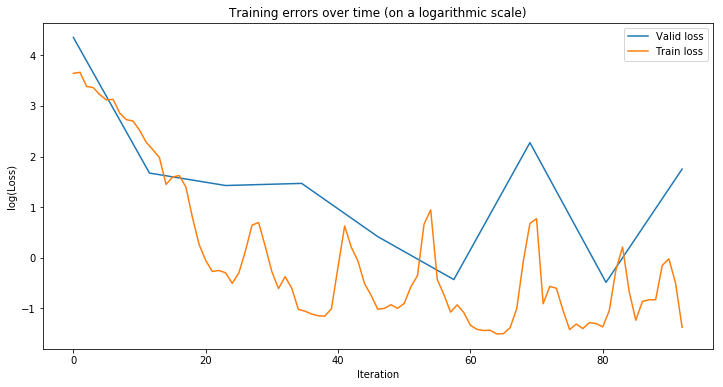

Visualizing 5 predictions:


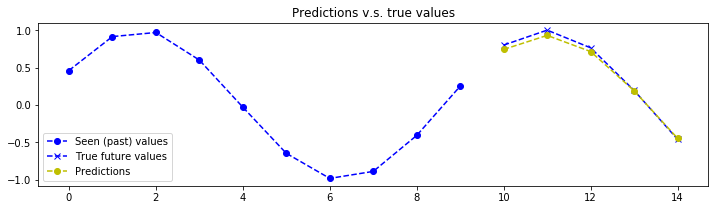

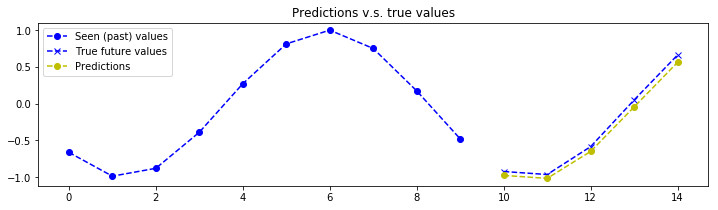

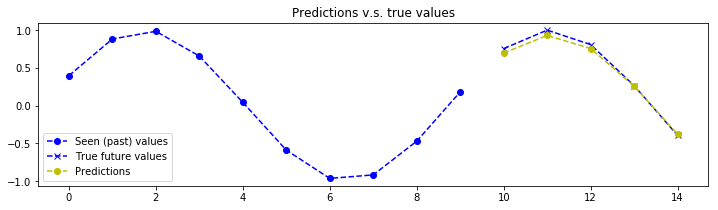

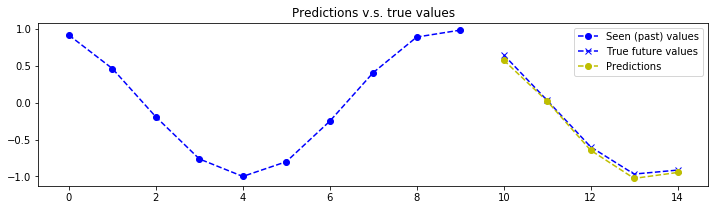

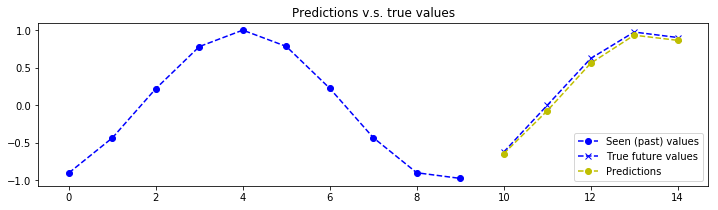

Experiment processing took 0.1 minutes
Model was saved to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/saved_models/exp1/saved_model
Model was exported to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/exported_models/exp1/1
Experiment "(('hidden_dim', 12), ('layers_stacked_count', 1), ('seq2seq_type', 'orig_tf_seq2seq'))
finished at 2019-04-08 20:46:20.255395-04:00
with the result: {'0_expId': 1, '1_TrLoss': 3.897303, '2_VaLoss': 12.196088, '3_Param#': '1.0K', '4_Exp.': 'hidden_dim12|layers_stacked_count1|seq2seq_typeorig_tf_seq2seq|', '5_Dur.': 0.1}

--------------------------------------------------
--------------------------------------------------
Running Experiment 2 of 8
Experiment: "(('hidden_dim', 12), ('layers_stacked_count', 1), ('seq2seq_type', 'decoder_feedback'))
Started at 2019-04-08 20:46:20.259712-04:00
Total number of model parameter: 1.022 K (1022)
Step 10/93.75, T

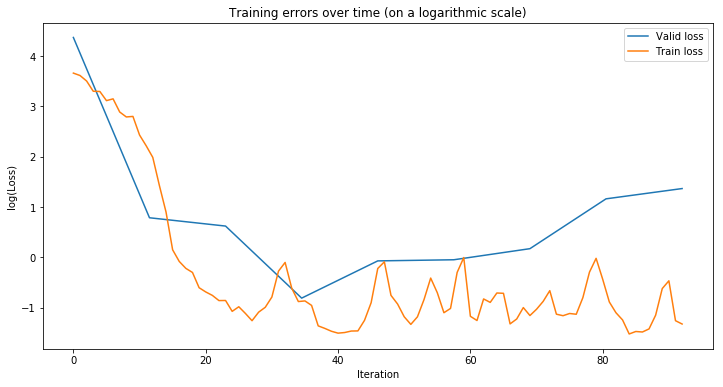

Visualizing 5 predictions:


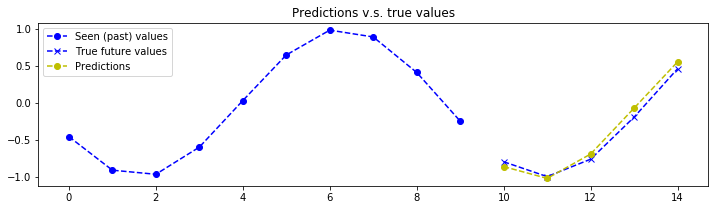

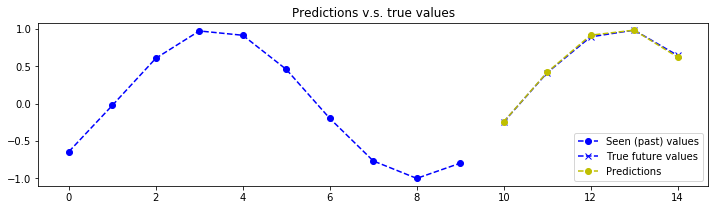

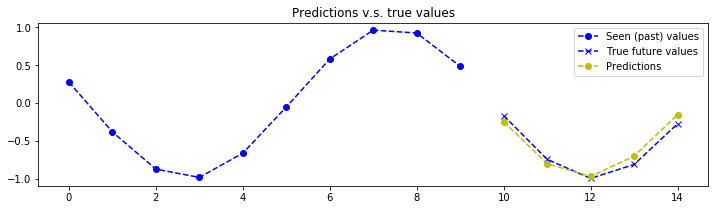

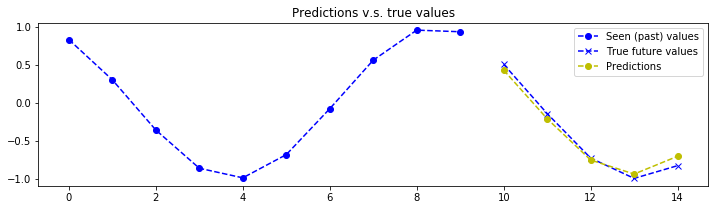

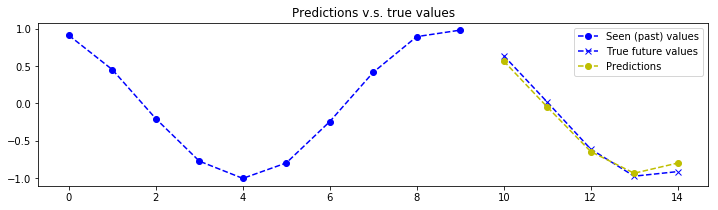

Experiment processing took 0.08 minutes
Model was saved to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/saved_models/exp2/saved_model
Model was exported to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/exported_models/exp2/1
Experiment "(('hidden_dim', 12), ('layers_stacked_count', 1), ('seq2seq_type', 'decoder_feedback'))
finished at 2019-04-08 20:46:26.272883-04:00
with the result: {'0_expId': 2, '1_TrLoss': 3.545562, '2_VaLoss': 10.424994, '3_Param#': '1.0K', '4_Exp.': 'hidden_dim12|layers_stacked_count1|seq2seq_typedecoder_feedback|', '5_Dur.': 0.08}

--------------------------------------------------
--------------------------------------------------
Running Experiment 3 of 8
Experiment: "(('hidden_dim', 12), ('layers_stacked_count', 2), ('seq2seq_type', 'orig_tf_seq2seq'))
Started at 2019-04-08 20:46:26.276717-04:00
Total number of model parameter: 2.822 K (2822)
Step 10/93.75

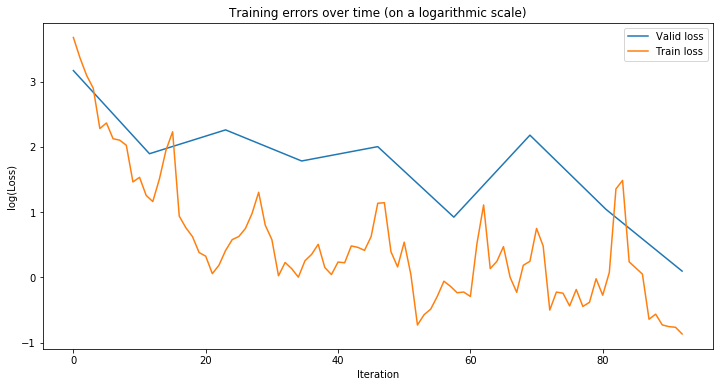

Visualizing 5 predictions:


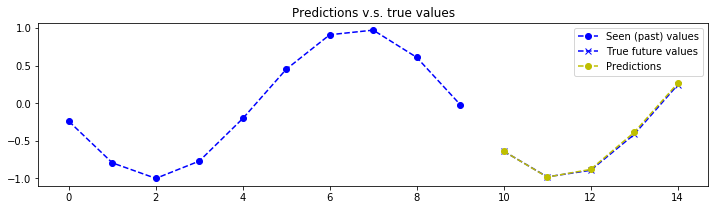

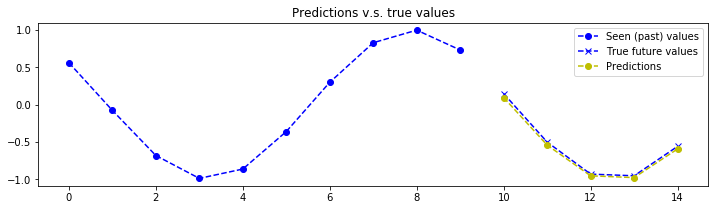

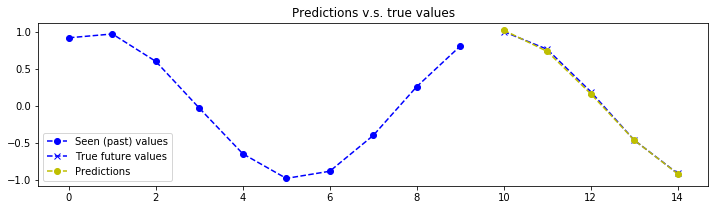

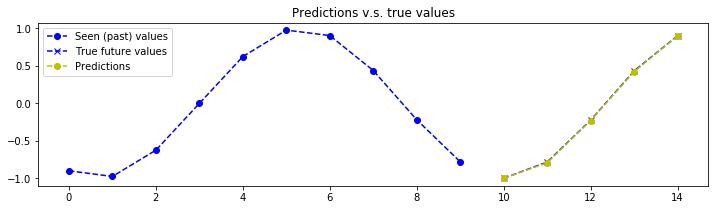

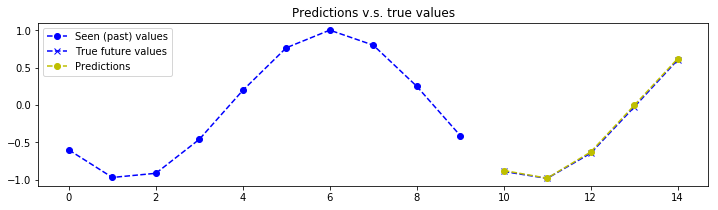

Experiment processing took 0.13 minutes
Model was saved to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/saved_models/exp3/saved_model
Model was exported to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/exported_models/exp3/1
Experiment "(('hidden_dim', 12), ('layers_stacked_count', 2), ('seq2seq_type', 'orig_tf_seq2seq'))
finished at 2019-04-08 20:46:35.741168-04:00
with the result: {'0_expId': 3, '1_TrLoss': 3.1882908, '2_VaLoss': 7.6271787, '3_Param#': '2.8K', '4_Exp.': 'hidden_dim12|layers_stacked_count2|seq2seq_typeorig_tf_seq2seq|', '5_Dur.': 0.13}

--------------------------------------------------
--------------------------------------------------
Running Experiment 4 of 8
Experiment: "(('hidden_dim', 12), ('layers_stacked_count', 2), ('seq2seq_type', 'decoder_feedback'))
Started at 2019-04-08 20:46:35.744798-04:00
Total number of model parameter: 2.822 K (2822)
Step 10/93.75

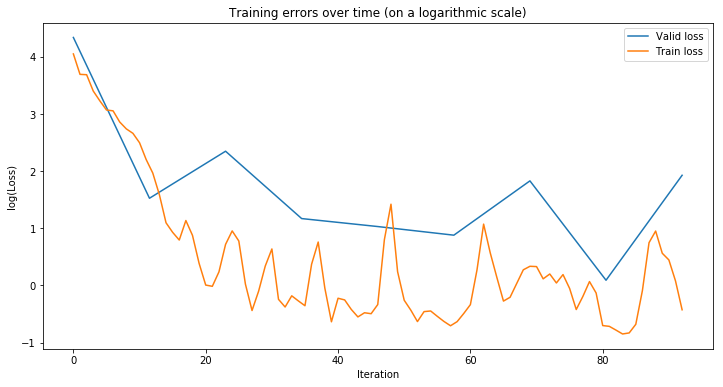

Visualizing 5 predictions:


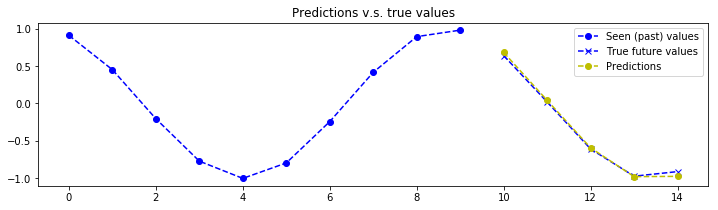

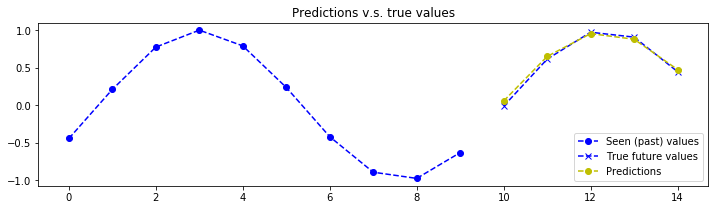

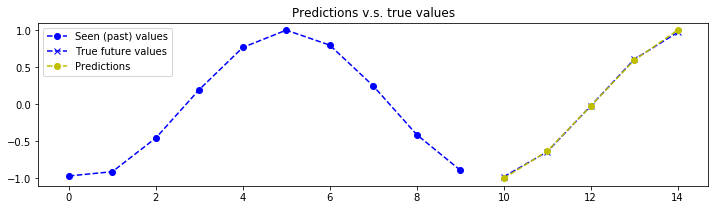

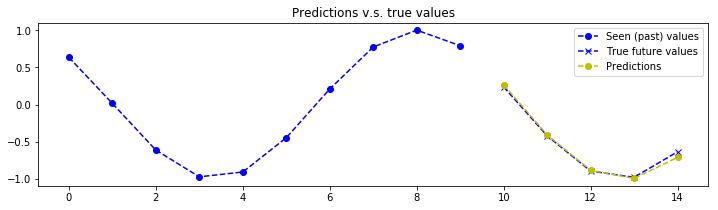

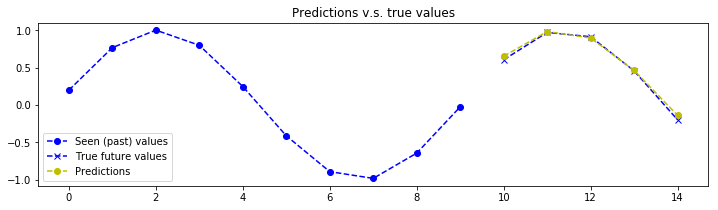

Experiment processing took 0.13 minutes
Model was saved to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/saved_models/exp4/saved_model
Model was exported to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/exported_models/exp4/1
Experiment "(('hidden_dim', 12), ('layers_stacked_count', 2), ('seq2seq_type', 'decoder_feedback'))
finished at 2019-04-08 20:46:44.972435-04:00
with the result: {'0_expId': 4, '1_TrLoss': 4.416516, '2_VaLoss': 12.693893, '3_Param#': '2.8K', '4_Exp.': 'hidden_dim12|layers_stacked_count2|seq2seq_typedecoder_feedback|', '5_Dur.': 0.13}

--------------------------------------------------
--------------------------------------------------
Running Experiment 5 of 8
Experiment: "(('hidden_dim', 24), ('layers_stacked_count', 1), ('seq2seq_type', 'orig_tf_seq2seq'))
Started at 2019-04-08 20:46:44.976125-04:00
Total number of model parameter: 3.77 K (3770)
Step 10/93.75,

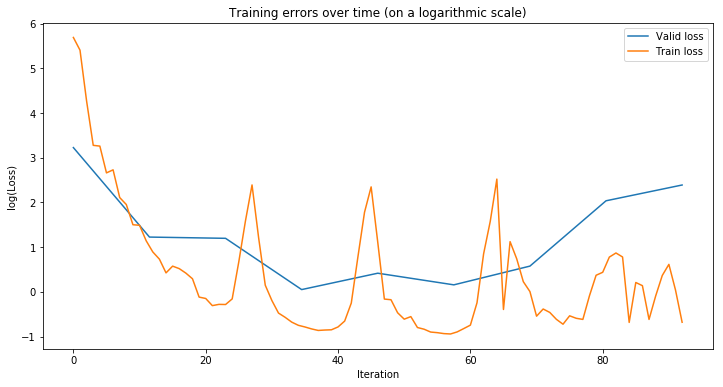

Visualizing 5 predictions:


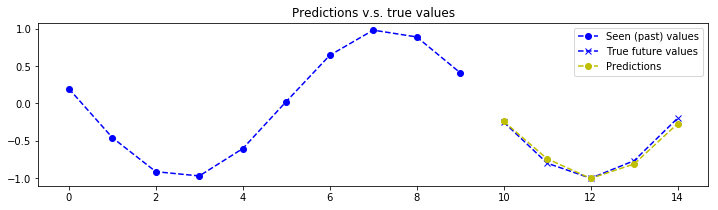

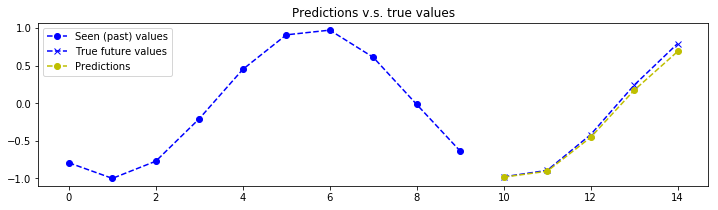

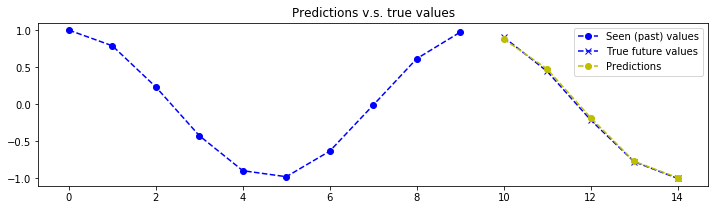

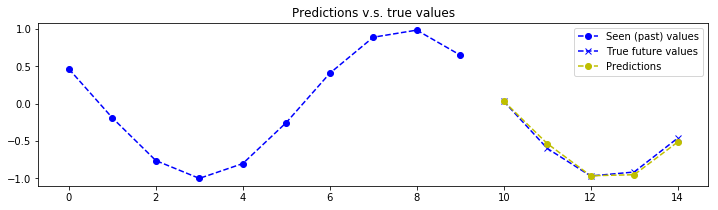

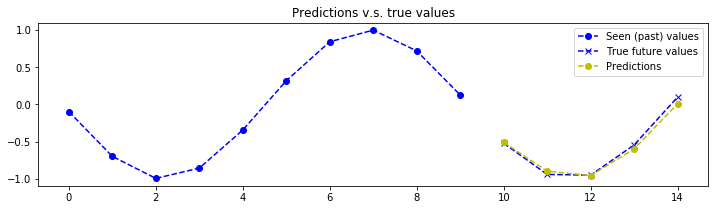

Experiment processing took 0.08 minutes
Model was saved to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/saved_models/exp5/saved_model
Model was exported to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/exported_models/exp5/1
Experiment "(('hidden_dim', 24), ('layers_stacked_count', 1), ('seq2seq_type', 'orig_tf_seq2seq'))
finished at 2019-04-08 20:46:50.431551-04:00
with the result: {'0_expId': 5, '1_TrLoss': 8.902707, '2_VaLoss': 6.2268324, '3_Param#': '3.8K', '4_Exp.': 'hidden_dim24|layers_stacked_count1|seq2seq_typeorig_tf_seq2seq|', '5_Dur.': 0.08}

--------------------------------------------------
--------------------------------------------------
Running Experiment 6 of 8
Experiment: "(('hidden_dim', 24), ('layers_stacked_count', 1), ('seq2seq_type', 'decoder_feedback'))
Started at 2019-04-08 20:46:50.435520-04:00
Total number of model parameter: 3.77 K (3770)
Step 10/93.75, 

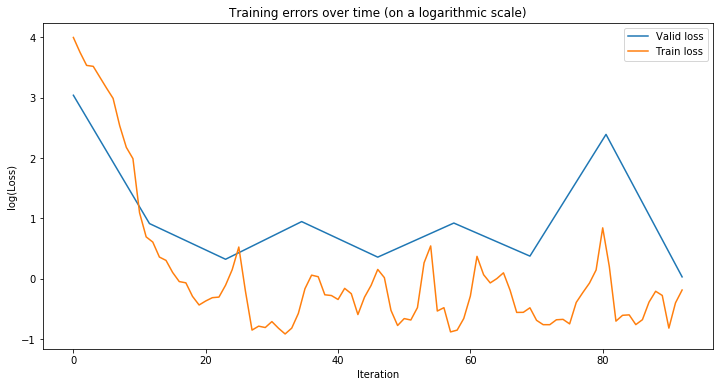

Visualizing 5 predictions:


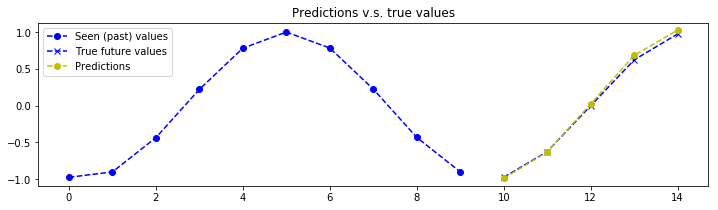

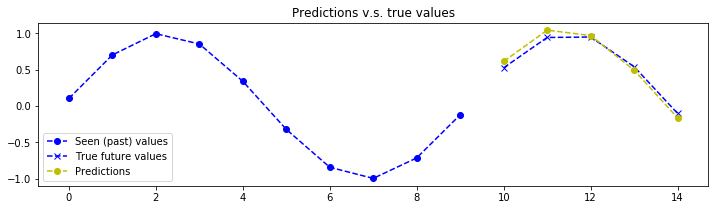

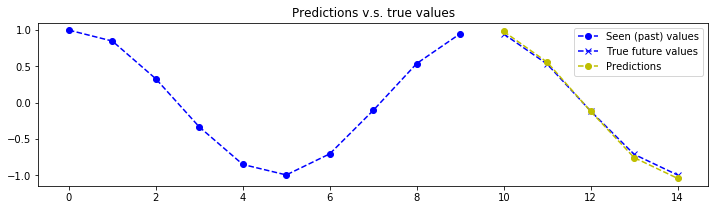

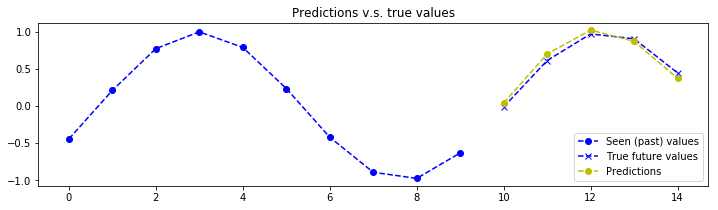

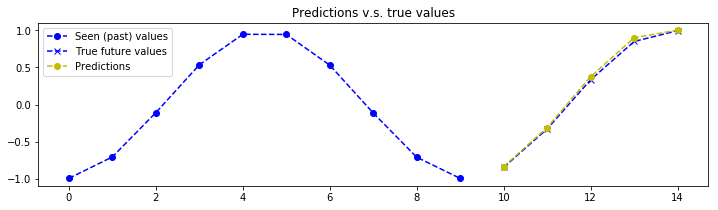

Experiment processing took 0.08 minutes
Model was saved to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/saved_models/exp6/saved_model
Model was exported to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/exported_models/exp6/1
Experiment "(('hidden_dim', 24), ('layers_stacked_count', 1), ('seq2seq_type', 'decoder_feedback'))
finished at 2019-04-08 20:46:56.094081-04:00
with the result: {'0_expId': 6, '1_TrLoss': 3.6043458, '2_VaLoss': 4.973012, '3_Param#': '3.8K', '4_Exp.': 'hidden_dim24|layers_stacked_count1|seq2seq_typedecoder_feedback|', '5_Dur.': 0.08}

--------------------------------------------------
--------------------------------------------------
Running Experiment 7 of 8
Experiment: "(('hidden_dim', 24), ('layers_stacked_count', 2), ('seq2seq_type', 'orig_tf_seq2seq'))
Started at 2019-04-08 20:46:56.097927-04:00
Total number of model parameter: 10.826 K (10826)
Step 10/93.

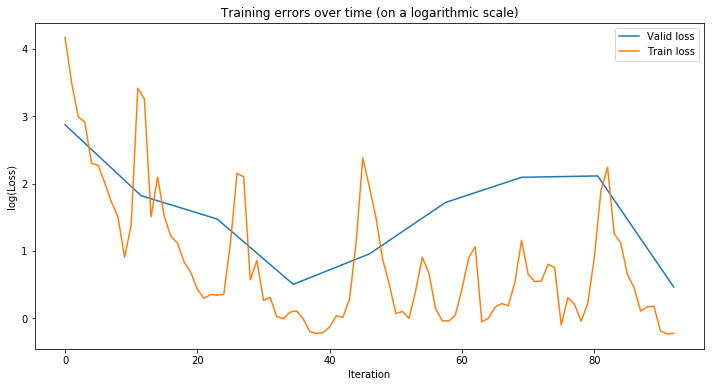

Visualizing 5 predictions:


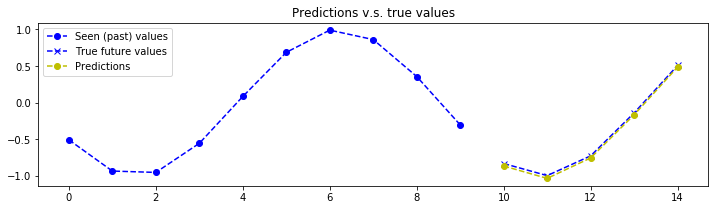

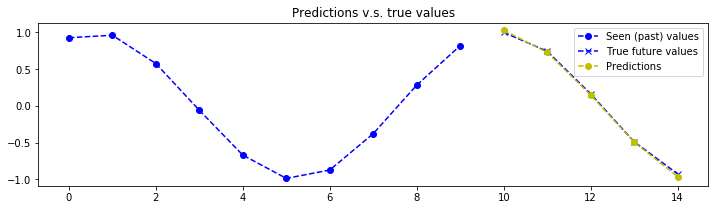

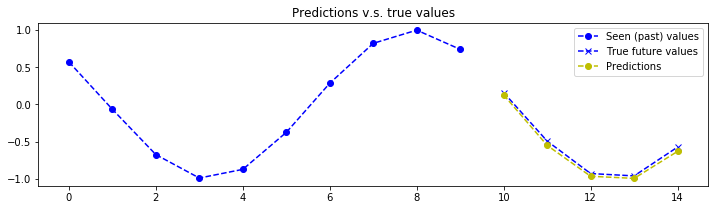

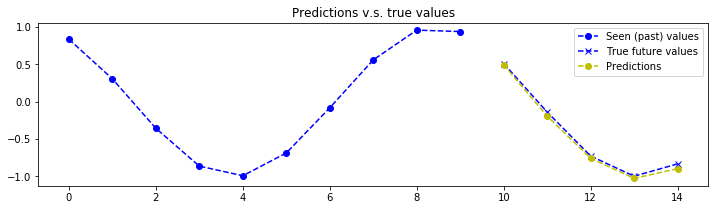

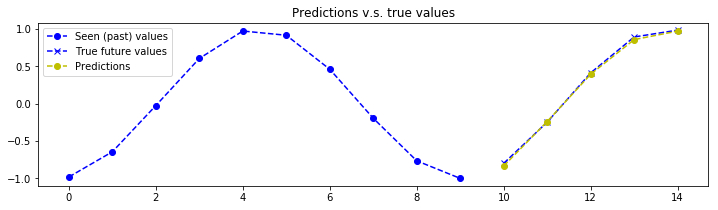

Experiment processing took 0.13 minutes
Model was saved to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/saved_models/exp7/saved_model
Model was exported to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/exported_models/exp7/1
Experiment "(('hidden_dim', 24), ('layers_stacked_count', 2), ('seq2seq_type', 'orig_tf_seq2seq'))
finished at 2019-04-08 20:47:05.105337-04:00
with the result: {'0_expId': 7, '1_TrLoss': 4.509425, '2_VaLoss': 6.223261, '3_Param#': '10.8K', '4_Exp.': 'hidden_dim24|layers_stacked_count2|seq2seq_typeorig_tf_seq2seq|', '5_Dur.': 0.13}

--------------------------------------------------
--------------------------------------------------
Running Experiment 8 of 8
Experiment: "(('hidden_dim', 24), ('layers_stacked_count', 2), ('seq2seq_type', 'decoder_feedback'))
Started at 2019-04-08 20:47:05.109106-04:00
Total number of model parameter: 10.826 K (10826)
Step 10/93.7

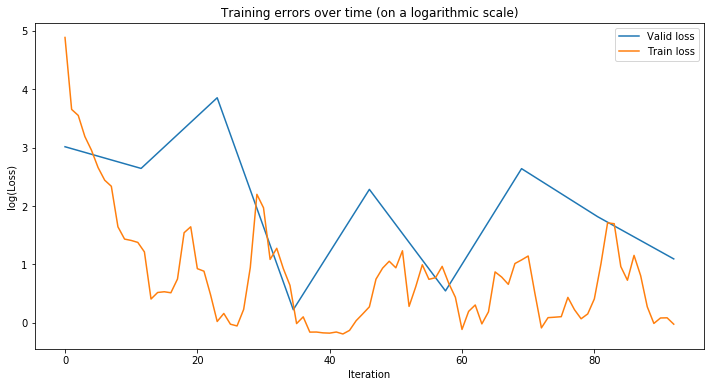

Visualizing 5 predictions:


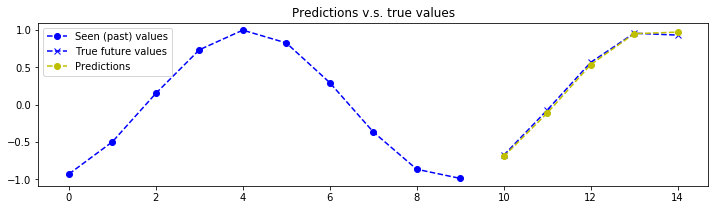

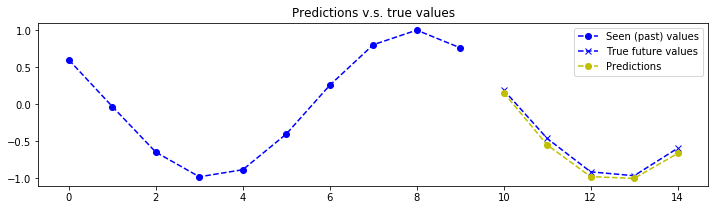

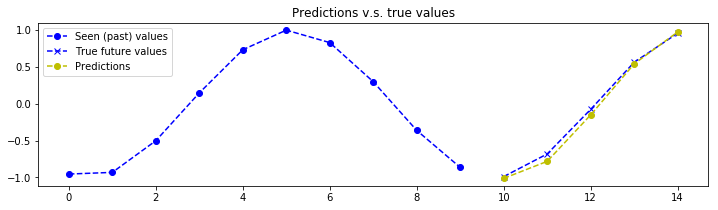

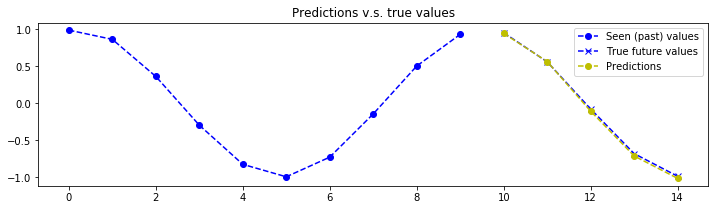

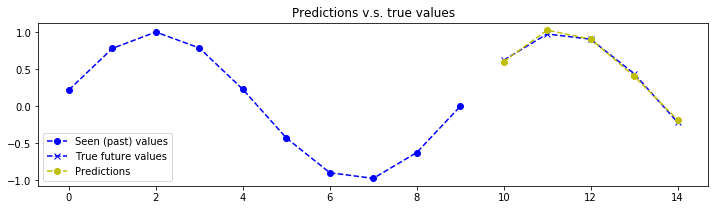

Experiment processing took 0.13 minutes
Model was saved to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/saved_models/exp8/saved_model
Model was exported to /workspace/notebooks/unianalytica/group/time-series-tf-serving-folder/time-series-tf-serving-full/exported_models/exp8/1
Experiment "(('hidden_dim', 24), ('layers_stacked_count', 2), ('seq2seq_type', 'decoder_feedback'))
finished at 2019-04-08 20:47:14.350572-04:00
with the result: {'0_expId': 8, '1_TrLoss': 5.0580535, '2_VaLoss': 13.055179, '3_Param#': '10.8K', '4_Exp.': 'hidden_dim24|layers_stacked_count2|seq2seq_typedecoder_feedback|', '5_Dur.': 0.13}
-------------------------------
-------------------------------


In [9]:
all_experiments = []
for element in itertools.product(*grid_params):
    all_experiments.append(element)

print('all_experiments {}:'.format(len(all_experiments)))
for x in all_experiments:
    print(str(x))

results = []
i = 1
for experiment in all_experiments:
    print('')
    print('--------------------------------------------------')
    print('--------------------------------------------------')
    print('Running Experiment ' + str(i) + ' of ' + str(len(all_experiments)))
    params['experiment_id'] = i
    print('Experiment: "' + str(experiment))
    print('Started at ' + str(datetime.now(pytz.timezone('US/Eastern'))))
    res = runExperiment(experiment, params, dataset_dict)
    print('Experiment "' + str(experiment))
    print('finished at '  + str(datetime.now(pytz.timezone('US/Eastern'))))
    print('with the result: ' + str(res))
    results.append(res)
    resultsDF = pd.DataFrame(results)
    resultsDF.to_csv(join(params['experiments_results_dir'],'experiments_resultsDF.csv'), sep=',', encoding='utf-8')
    i += 1

print('-------------------------------')
print('-------------------------------')

### Best experiment/model according to validation set results is determined

In [10]:
#resultsDF = pd.read_csv(join(params['experiments_results_dir'],'experiments_resultsDF.csv'), sep=',', index_col=0, header=0)
resultsDF = resultsDF.sort_values(['2_VaLoss'], ascending=[1])
resultsDF_first_choice_ix = resultsDF.index.tolist()[0]
chosen_exp_id = resultsDF.at[resultsDF_first_choice_ix, '0_expId']
print('Experiment with ID of {} has the lowest validation loss during training.'.format(chosen_exp_id))

print('All results:')
print(resultsDF)

now = datetime.now(pytz.timezone('US/Eastern'))
seconds_since_epoch_overall_end = time.mktime(now.timetuple())

print()
print('Processing all experiments took ' + str( np.around( (seconds_since_epoch_overall_end - seconds_since_epoch_overall_start)/60.0 , decimals=2) ) + ' minutes')

Experiment with ID of 6 has the lowest validation loss during training.
All results:
   0_expId  1_TrLoss   2_VaLoss 3_Param#  \
5        6  3.604346   4.973012     3.8K   
6        7  4.509425   6.223261    10.8K   
4        5  8.902707   6.226832     3.8K   
2        3  3.188291   7.627179     2.8K   
1        2  3.545562  10.424994     1.0K   
0        1  3.897303  12.196088     1.0K   
3        4  4.416516  12.693893     2.8K   
7        8  5.058053  13.055179    10.8K   

                                              4_Exp.  5_Dur.  
5  hidden_dim24|layers_stacked_count1|seq2seq_typ...    0.08  
6  hidden_dim24|layers_stacked_count2|seq2seq_typ...    0.13  
4  hidden_dim24|layers_stacked_count1|seq2seq_typ...    0.08  
2  hidden_dim12|layers_stacked_count2|seq2seq_typ...    0.13  
1  hidden_dim12|layers_stacked_count1|seq2seq_typ...    0.08  
0  hidden_dim12|layers_stacked_count1|seq2seq_typ...    0.10  
3  hidden_dim12|layers_stacked_count2|seq2seq_typ...    0.13  
7  hidden_dim2

### Picking the best model based on validation set results and reporting its result on the test set

In [11]:
chosen_exp_id = None # If None, the experiment having the lowest loss on validation set is chosen

batch_size = params['batch_size']
is_plotting_predictions = params['is_plotting_predictions']
nb_predictions = params['nb_predictions']
output_dim = params['output_dim']
seq_length_out = params['seq_length_out']

testset_x = dataset_dict['testset_x']
testset_y = dataset_dict['testset_y']

n_batch_test = len(testset_x) // batch_size
testset_len = n_batch_test * batch_size

if chosen_exp_id == None:
    resultsDF = pd.read_csv(join(params['experiments_results_dir'],'experiments_resultsDF.csv'), sep=',', index_col=0, header=0)
    resultsDF = resultsDF.sort_values(['2_VaLoss'], ascending=[1])
    resultsDF_first_choice_ix = resultsDF.index.tolist()[0]
    chosen_exp_id = resultsDF.at[resultsDF_first_choice_ix, '0_expId']

print("Testing model with exp_id {}".format(chosen_exp_id))

print('Experiment label: ', resultsDF.at[resultsDF_first_choice_ix, '4_Exp.'])

model_save_path = join(params['saved_models_dir'],'exp'+str(chosen_exp_id),'saved_model')

Testing model with exp_id 6
Experiment label:  hidden_dim24|layers_stacked_count1|seq2seq_typedecoder_feedback|


### Loading the saved model, predicting on testset, and plotting some predictions

Model successfully restored
Predictions done for batch #1 of 6
Predictions done for batch #2 of 6
Predictions done for batch #3 of 6
Predictions done for batch #4 of 6
Predictions done for batch #5 of 6
Predictions done for batch #6 of 6
Predictions on testset done. Shape of predictions array: (192, 1, 5)
Test loss: 0.5846724510192871
Visualizing 5 predictions:


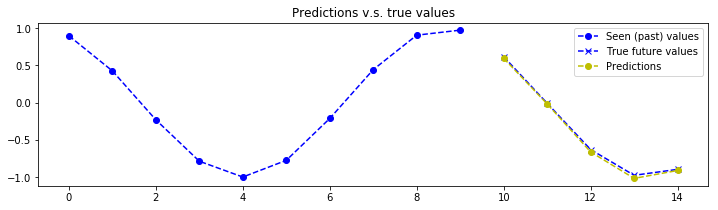

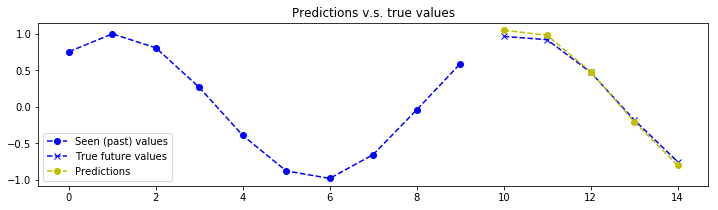

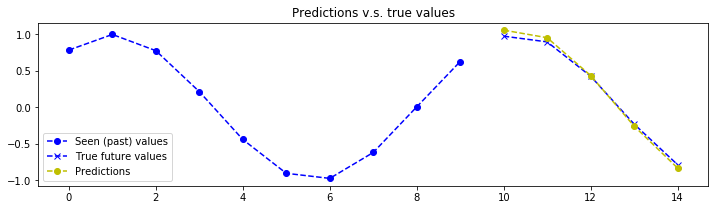

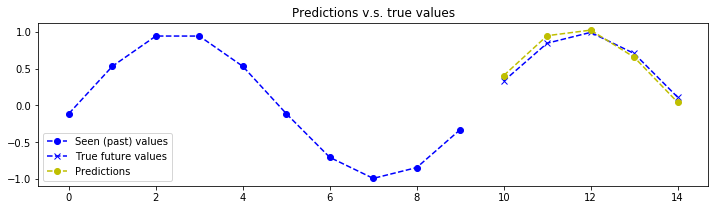

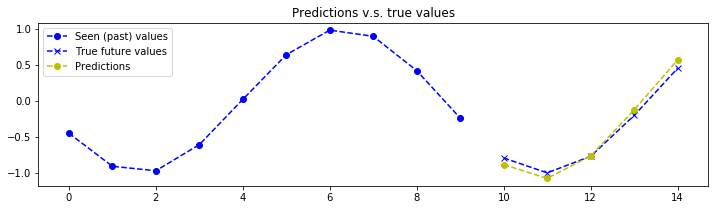

In [12]:
graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(model_save_path+'.meta')
        saver.restore(sess, model_save_path)
        graph = tf.get_default_graph()
        enc_inp_tensor = graph.get_tensor_by_name("Seq2seq/enc_inp_tensor:0")
        expected_output_tensor = graph.get_tensor_by_name("Seq2seq/expected_output_tensor:0")
        reshaped_outputs_tensor = graph.get_tensor_by_name("Seq2seq/reshaped_outputs_tensor:0")
        loss_tensor = graph.get_tensor_by_name("Loss/loss:0")

        print('Model successfully restored')
        
        test_losses = []        
        predictions = np.zeros(shape=(testset_len, output_dim, seq_length_out)) # (batch, dimension/KPIs, time)
        for i in range(n_batch_test):
            print('Predictions done for batch #{} of {}'.format(i+1,n_batch_test))
            test_x = testset_x[i * batch_size: i * batch_size + batch_size].transpose((1, 0, 2)) # reshaped to (seq_length_in, batch_size, input_dim)
            test_y = testset_y[i * batch_size: i * batch_size + batch_size].transpose((1, 0, 2))
            feed_dict = {enc_inp_tensor: test_x}
            feed_dict.update({expected_output_tensor: test_y})
            predictions_batch, test_loss = sess.run([reshaped_outputs_tensor, loss_tensor], feed_dict)
            test_losses.append(test_loss)
            predictions[i * batch_size: i * batch_size + batch_size] = predictions_batch.transpose((1, 2, 0)) # reshaped to (batch_size, output_dim, seq_length_out)
        print('Predictions on testset done. Shape of predictions array: {}'.format(predictions.shape))

        mean_test_loss = np.mean(test_losses)
        print("Test loss: {}".format(mean_test_loss))
        
        if is_plotting_predictions:
            print("Visualizing {} predictions:".format(nb_predictions))

            indices = np.random.choice(len(predictions), size= nb_predictions, replace=False)

            X = np.array(itemgetter(*indices)(testset_x)).transpose((1, 0, 2))
            Y = np.array(itemgetter(*indices)(testset_y)).transpose((1, 0, 2))
            outputs = np.array(itemgetter(*indices)(predictions)).transpose((2, 0, 1))

            for j in range(nb_predictions): 
                plt.figure(figsize=(12, 3))

                for k in range(input_dim):
                    past = X[:,j,k]
                    label1 = "Seen (past) values" if k==0 else "_nolegend_"
                    plt.plot(range(len(past)), past, "o--b", label=label1)

                for k in range(output_dim):
                    expected = Y[:,j,k]
                    pred = outputs[:,j,k]

                    label2 = "True future values" if k==0 else "_nolegend_"
                    label3 = "Predictions" if k==0 else "_nolegend_"
                    plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label=label2)
                    plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)

                plt.legend(loc='best')
                plt.title("Predictions v.s. true values")
                plt.show()